## Normalization example

expanded on https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html#real-world-data-set

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from distutils.version import LooseVersion

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.datasets import load_boston
from sklearn.preprocessing import QuantileTransformer, quantile_transform
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [2]:
# `normed` is being deprecated in favor of `density` in histograms
if LooseVersion(matplotlib.__version__) >= '2.1':
    density_param = {'density': True}
else:
    density_param = {'normed': True}

## Load dataset

In [3]:
dataset = load_boston()
target = np.array(dataset.feature_names) == "DIS"
X = dataset.data[:, np.logical_not(target)]
y = dataset.data[:, target].squeeze()
y_trans = quantile_transform(dataset.data[:, target],
                             n_quantiles=300,
                             output_distribution='normal',
                             copy=True).squeeze()

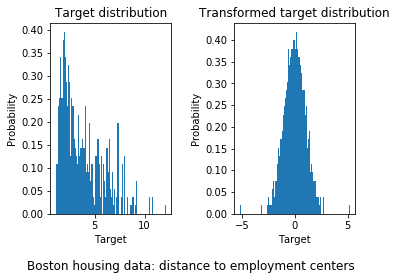

In [4]:
f, (ax0, ax1) = plt.subplots(1, 2)

ax0.hist(y, bins=100, **density_param)
ax0.set_ylabel('Probability')
ax0.set_xlabel('Target')
ax0.set_title('Target distribution')

ax1.hist(y_trans, bins=100, **density_param)
ax1.set_ylabel('Probability')
ax1.set_xlabel('Target')
ax1.set_title('Transformed target distribution')

f.suptitle("Boston housing data: distance to employment centers", y=0.035)
f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

## Create baseline

In [5]:
regr = RidgeCV()
regr.fit(X_train, y_train)
y_pred_baseline = regr.predict(X_test)

## Do grid search

In [6]:
# Create a pipeline
pipe = Pipeline([('feature_selection', SelectFromModel(ExtraTreesRegressor())),
                 ('regressor', TransformedTargetRegressor(
                                    regressor=RidgeCV(),
                                    transformer=QuantileTransformer(n_quantiles=300,
                                                                    output_distribution='normal'))),
                 
                ])

# Create space of candidate learning algorithms and their hyperparameters
search_space = [
                {
                    'regressor__regressor': [RandomForestRegressor()],
                    'regressor__regressor__n_estimators': [10, 100, 1000]
                },
                {
                    'regressor__regressor': [Ridge()]
                },
                {
                    'regressor__regressor': [KNeighborsRegressor()],
                    'regressor__regressor__n_neighbors': range(2,8)
                }
               ]

# Create grid search 
clf = GridSearchCV(pipe, search_space, scoring='neg_mean_absolute_error', cv=5, verbose=0)


# Fit grid search
best_model = clf.fit(X_train, y_train)

In [7]:
best_model.best_estimator_['regressor'].regressor

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [8]:
y_pred = best_model.predict(X_test)

## Check if gridsearch had improvement

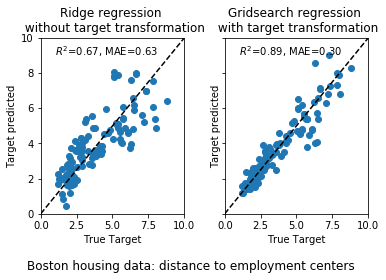

In [9]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

ax0.scatter(y_test, y_pred_baseline)
ax0.plot([0, 10], [0, 10], '--k')
ax0.set_ylabel('Target predicted')
ax0.set_xlabel('True Target')
ax0.set_title('Ridge regression \n without target transformation')
ax0.text(1, 9, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_score(y_test, y_pred_baseline), median_absolute_error(y_test, y_pred_baseline)))
ax0.set_xlim([0, 10])
ax0.set_ylim([0, 10])

ax1.scatter(y_test, y_pred)
ax1.plot([0, 10], [0, 10], '--k')
ax1.set_ylabel('Target predicted')
ax1.set_xlabel('True Target')
ax1.set_title('Gridsearch regression \n with target transformation')
ax1.text(1, 9, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_score(y_test, y_pred), median_absolute_error(y_test, y_pred)))
ax1.set_xlim([0, 10])
ax1.set_ylim([0, 10])

f.suptitle("Boston housing data: distance to employment centers", y=0.035)
f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

plt.show()

## Save model

We can save our best model, which also contains the feature selection step and the normalization/denormalization, so users of the model do not have to know any specifics.

In [10]:
from joblib import dump, load
dump(best_model, './model.joblib')

['./model.joblib']

In [11]:
from zipfile import ZipFile
from io import BytesIO
import requests
from requests.auth import HTTPBasicAuth

In [12]:
def upload_model(model_name, description, upload_url, api_key, api_secret):
    
    zipfile_name = 'model.zip'
    # Create a zip
    with ZipFile('model.zip', 'w') as zipfile:
       # Add multiple files to the zip
       zipfile.write('model.joblib')
        
    with open('model.zip', 'rb') as f:
        upload_file = BytesIO(f.read())
        
    # upload to waylay
    resp = requests.post(upload_url,
                         files={"file": ('model.zip', upload_file)},
                         data={"name": model_name, "framework": "sklearn", "description": description},
                         auth=HTTPBasicAuth(api_key, api_secret))

    return resp.json()

In [13]:
# https://docs.waylay.io/api/rest/#authentication
api_key = 'your api key'
api_secret = 'your api secret'
byom_url = 'your byom url'
model_name = 'sklearn-demo
print(upload_model(model_name, 
                   'A model to predict the weighted distance to five Boston employment centers, '
                   'using the following features: '
                   'CRIM per capita crime rate by town, '
                   'ZN proportion of residential land zoned for lots over 25,000 sq.ft. '
                   'INDUS proportion of non-retail business acres per town, '
                   'CHAS Charles River dummy variable (= 1 if tract bounds river; 0 otherwise), '
                   'NOX nitric oxides concentration (parts per 10 million)RM average number of rooms per dwelling, '
                   'AGE proportion of owner-occupied units built prior to 1940, '
                   'DIS weighted distances to five Boston employment centres, '
                   'RAD index of accessibility to radial highways,'
                   'TAX full-value property-tax rate per $10,000, '
                   'PTRATIO pupil-teacher ratio by town, '
                   'B 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town, '
                   'LSTAT % lower status of the population. '
                   'MEDV Median value of owner-occupied homes in $1000\'s', 
                   byom_url, 
                   api_key, 
                   api_secret
                  )
     )


{'message': 'Model successfully uploaded'}


## Check if upload worked

In [14]:
best_model.predict(X_test[:2]).tolist()

[3.697235470373196, 3.7945884300486736]

In [16]:
requests.post(byom_url + '/' + model_name + '/predict',
              json = {"instances": X_test[:2].tolist()},
              auth=HTTPBasicAuth(api_key, api_secret)).json()

{'predictions': [3.697235470373196, 3.7945884300486736]}